# Actividad 4.2
## Ejercicio de Detección de Señales de Tránsito

---

### Integrantes del Equipo 23:
* Carlos Pano Hernández - A01066264 [Campus Estado de México]
* Marie Kate Palau - A01705711 [Campus Monterrey]
* Edson Ulises Rodríguez Dávalos - A01796057 [Campus CdMx]
* Yohanna Ceballos Salomón - A01795115 [Campus Monterrey]

---

### Escuela de Ingeniería y Ciencias, Tecnológico de Monterrey
**Navegación autónoma (MR4010 - Gpo 10)**

---

#### Profesor Titular:
Dr. David Antonio Torres

#### Profesor Asistente:
Mtra. María Mylen Treviño Elizondo

---

**Sábado 07 de junio del 2025**

# 1. Library Imports and Setup
This section contains all the necessary library imports for data manipulation, image processing, deep learning, and visualization that we'll use throughout this notebook.

In [5]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Load CSV files
train_df = pd.read_csv('data/Train.csv')
test_df = pd.read_csv('data/Test.csv')

# 2. Data Loading and Preprocessing
This section handles loading the training and test data from CSV files, extracting key image dimensions, and setting up important constants that will be used throughout the model training process.
#
The data is preprocessed by:
- Loading images and resizing them to consistent dimensions ({IMG_WIDTH}x{IMG_HEIGHT})
- Normalizing pixel values to [0,1] range by dividing by 255
- Converting images to numpy arrays for model training
- Extracting class labels from the CSV files

In [6]:
# Get median dimensions from training data
IMG_WIDTH = int(train_df['Width'].median())
IMG_HEIGHT = int(train_df['Height'].median())
NUM_CHANNELS = 3  # RGB images
NUM_CLASSES = len(train_df['ClassId'].unique())  # Number of traffic sign classes

print(f"Image dimensions: {IMG_WIDTH}x{IMG_HEIGHT}")
print(f"Number of classes: {NUM_CLASSES}")

# Function to load, resize and normalize images
def load_and_preprocess_image(file_path):
    img = Image.open(file_path).resize((IMG_WIDTH, IMG_HEIGHT))  # Load and resize
    img_array = np.array(img) / 255.0  # Convert to array and normalize
    return img_array

# Load training data
X_train = np.array([load_and_preprocess_image(os.path.join('data', path)) for path in train_df['Path']])
y_train = train_df['ClassId'].values

# Load test data
X_test = np.array([load_and_preprocess_image(os.path.join('data', path)) for path in test_df['Path']])
y_test = test_df['ClassId'].values

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Image dimensions: 43x43
Number of classes: 43
Training data shape: (39209, 43, 43, 3)
Test data shape: (12630, 43, 43, 3)


# 3. Model Architecture
The following code block defines and compiles our CNN model architecture for traffic sign classification. The model consists of:
#
- Three convolutional blocks with increasing filter sizes (32->64->128)
- Each block contains:
   - Two Conv2D layers with batch normalization
   - MaxPooling2D for dimensionality reduction
   - Dropout for regularization (increasing from 0.25 to 0.4)
 - Dense layers for final classification:
   - Flattening layer to convert 3D feature maps to 1D
   - 512-unit dense layer with batch normalization and dropout
   - Final softmax layer with NUM_CLASSES units

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 43, 43, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 43, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 43, 43, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 43, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 21, 21, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,638,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,951,819 (7.45 MB)

 Trainable params: 1,949,899 (7.44 MB)

 Non-trainable params: 1,920 (7.50 KB)

None


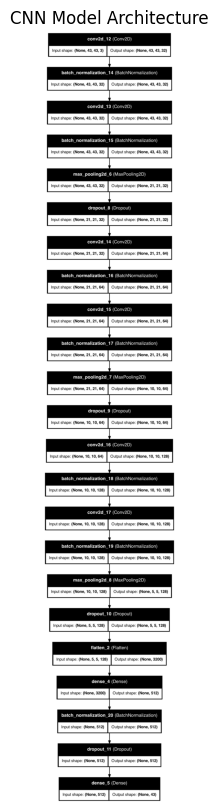

In [11]:
# Shuffle training data before splitting
indices = np.arange(len(X_train))
np.random.shuffle(indices)
X_train = X_train[indices]
y_train = y_train[indices]

# Configure data augmentation with validation split
datagen = ImageDataGenerator(
    rotation_range=10,      # Random rotation up to 10 degrees
    zoom_range=0.1,        # Random zoom up to 10%
    width_shift_range=0.1,  # Random horizontal shift up to 10%
    height_shift_range=0.1, # Random vertical shift up to 10%
    horizontal_flip=False,  # No flipping since signs must maintain orientation
    validation_split=0.2    # 20% validation split
)
datagen.fit(X_train)

# Define CNN architecture
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)),
    
    # First conv block - 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    # Second conv block - 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.35),

    # Third conv block - 128 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.4),

    # Dense layers for classification
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Configure model training
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print(model.summary())

# Setup training callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
model_ckpt = ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy', mode='max')

# Visualize model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(10,10))
img = plt.imread('model_architecture.png')
plt.imshow(img)
plt.axis('off')
plt.title("CNN Model Architecture")
plt.show()

# 4. Model Training and Evaluation
In this section, we train the CNN model on our traffic sign dataset and evaluate its performance. We use sparse categorical crossentropy loss, the Adam optimizer with a learning rate of 0.001, and track both accuracy and loss metrics during training. The model is trained for 30 epochs with a batch size of 64, using early stopping, learning rate reduction, and model checkpointing callbacks.

In [8]:
# Train Model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64, subset='training'),
    validation_data=datagen.flow(X_train, y_train, batch_size=64, subset='validation'),
    epochs=4,
    callbacks=[early_stop, reduce_lr, model_ckpt],
    verbose=1
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'\n✅ Test accuracy: {test_acc:.4f}')
print(f'❌ Test loss: {test_loss:.4f}')

Epoch 1/4


/opt/anaconda3/envs/master-ai-tec/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


491/491 ━━━━━━━━━━━━━━━━━━━━ 68s 135ms/step - accuracy: 0.3184 - loss: 2.7813 - val_accuracy: 0.5814 - val_loss: 1.3391 - learning_rate: 0.0010
Epoch 2/4
491/491 ━━━━━━━━━━━━━━━━━━━━ 60s 122ms/step - accuracy: 0.8292 - loss: 0.5271 - val_accuracy: 0.9633 - val_loss: 0.1173 - learning_rate: 0.0010
Epoch 3/4
491/491 ━━━━━━━━━━━━━━━━━━━━ 63s 129ms/step - accuracy: 0.9312 - loss: 0.2205 - val_accuracy: 0.9811 - val_loss: 0.0660 - learning_rate: 0.0010
Epoch 4/4
491/491 ━━━━━━━━━━━━━━━━━━━━ 63s 128ms/step - accuracy: 0.9583 - loss: 0.1331 - val_accuracy: 0.9894 - val_loss: 0.0356 - learning_rate: 0.0010
395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9727 - loss: 0.0832

✅ Test accuracy: 0.9707
❌ Test loss: 0.0851


# 5. Visualizing Training Results
The following section creates plots to visualize the model's training progress, showing both the loss and accuracy metrics over epochs for training and validation data.

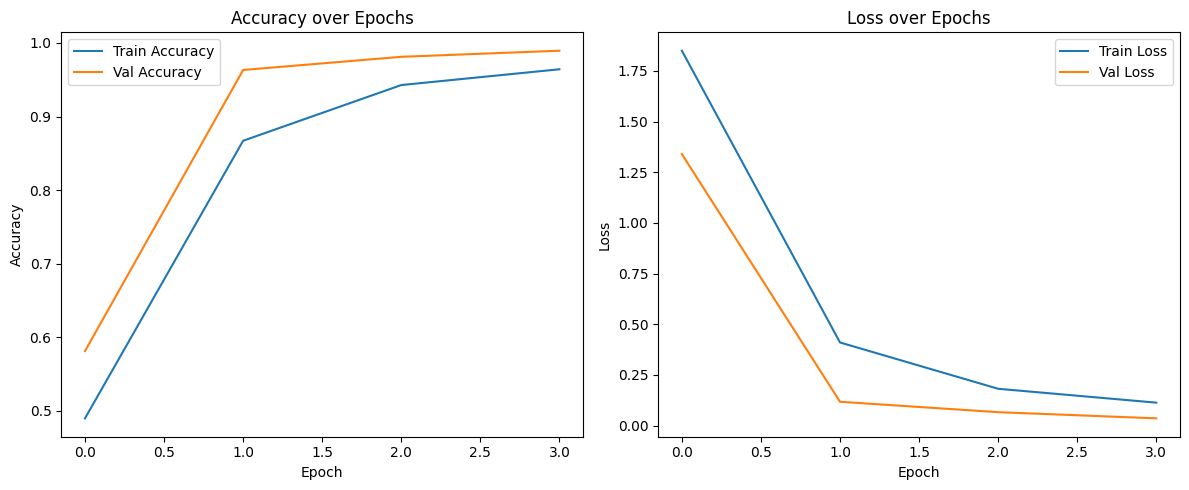

In [9]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 6. Testing with Multiple Sample Images
The following section demonstrates how to use the trained model to classify multiple traffic sign images. We load, preprocess, and predict on test images from the Meta folder to verify the model's performance on real-world data. The images are displayed in a grid format with their predicted sign types.

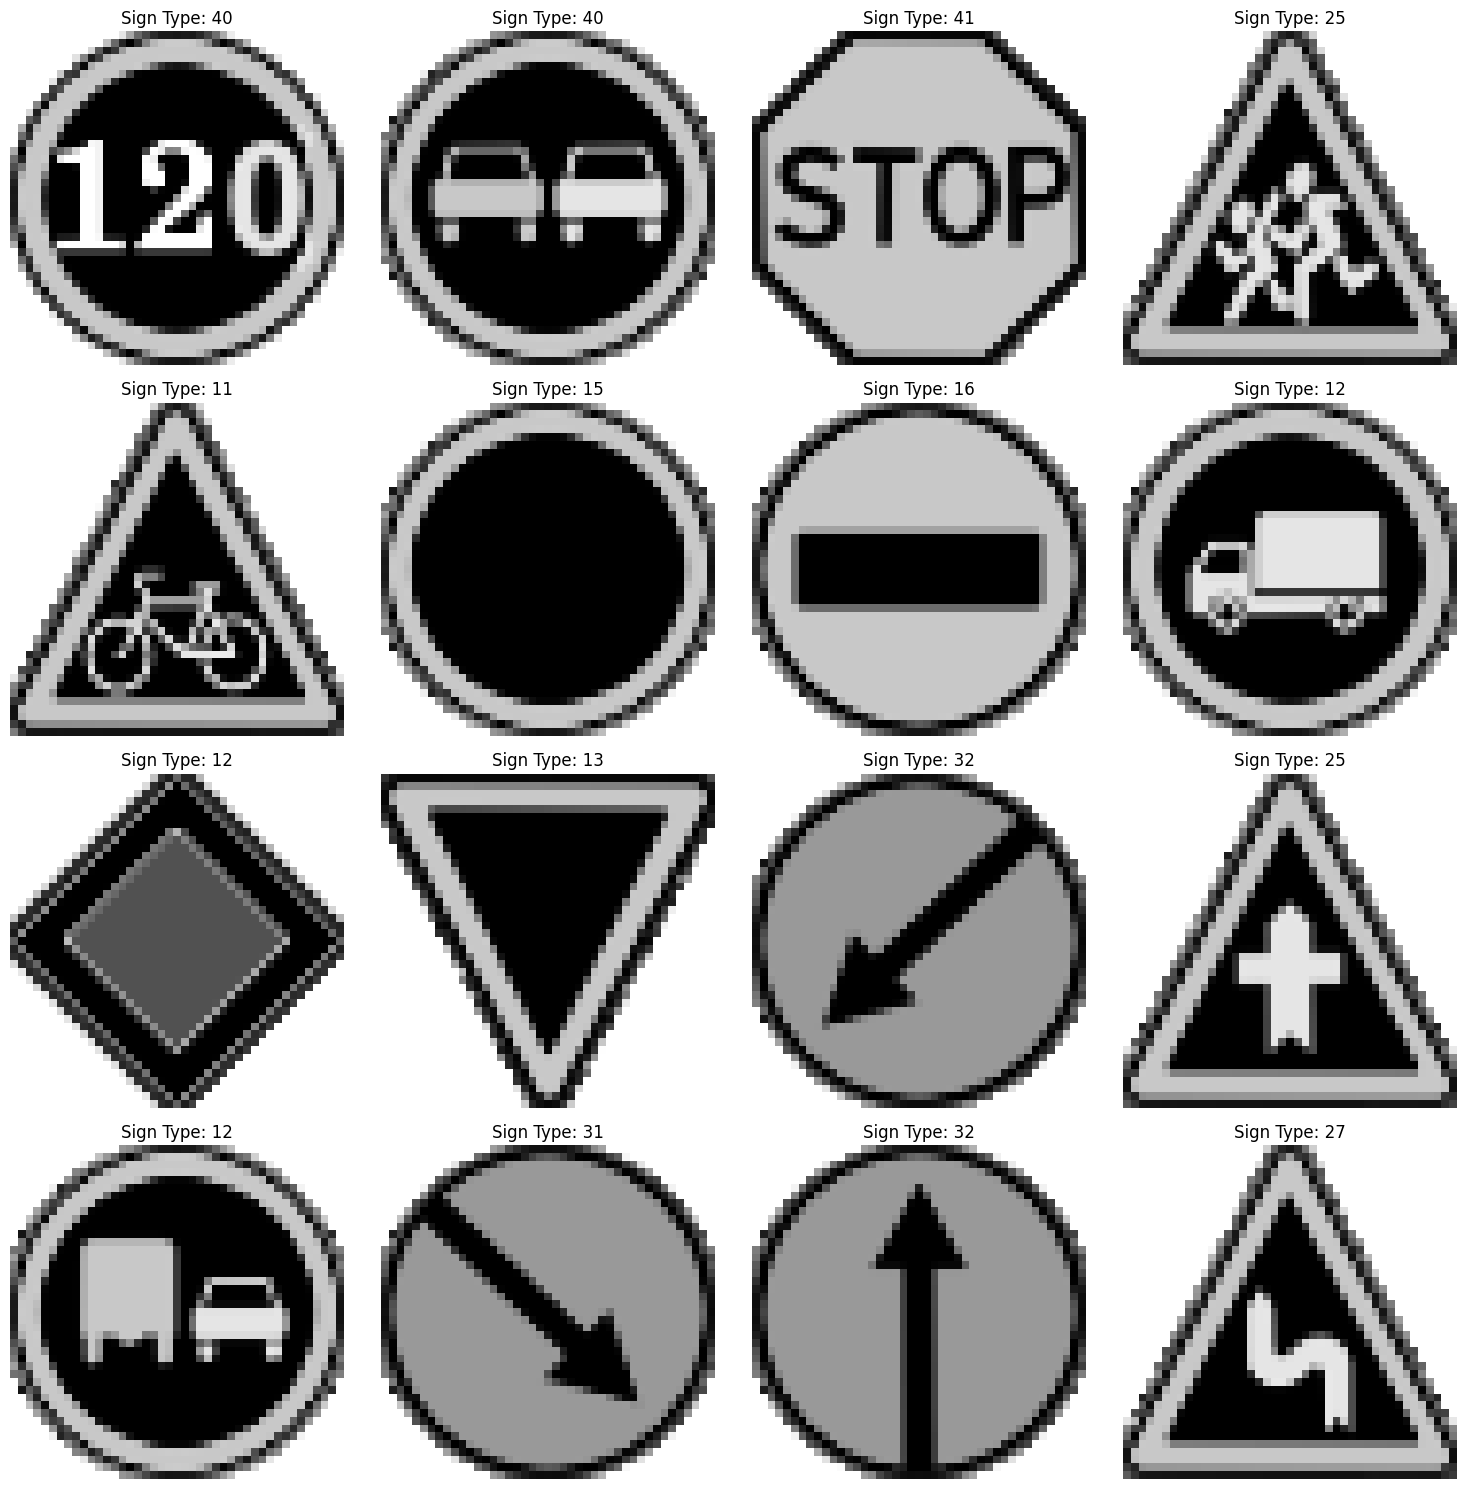

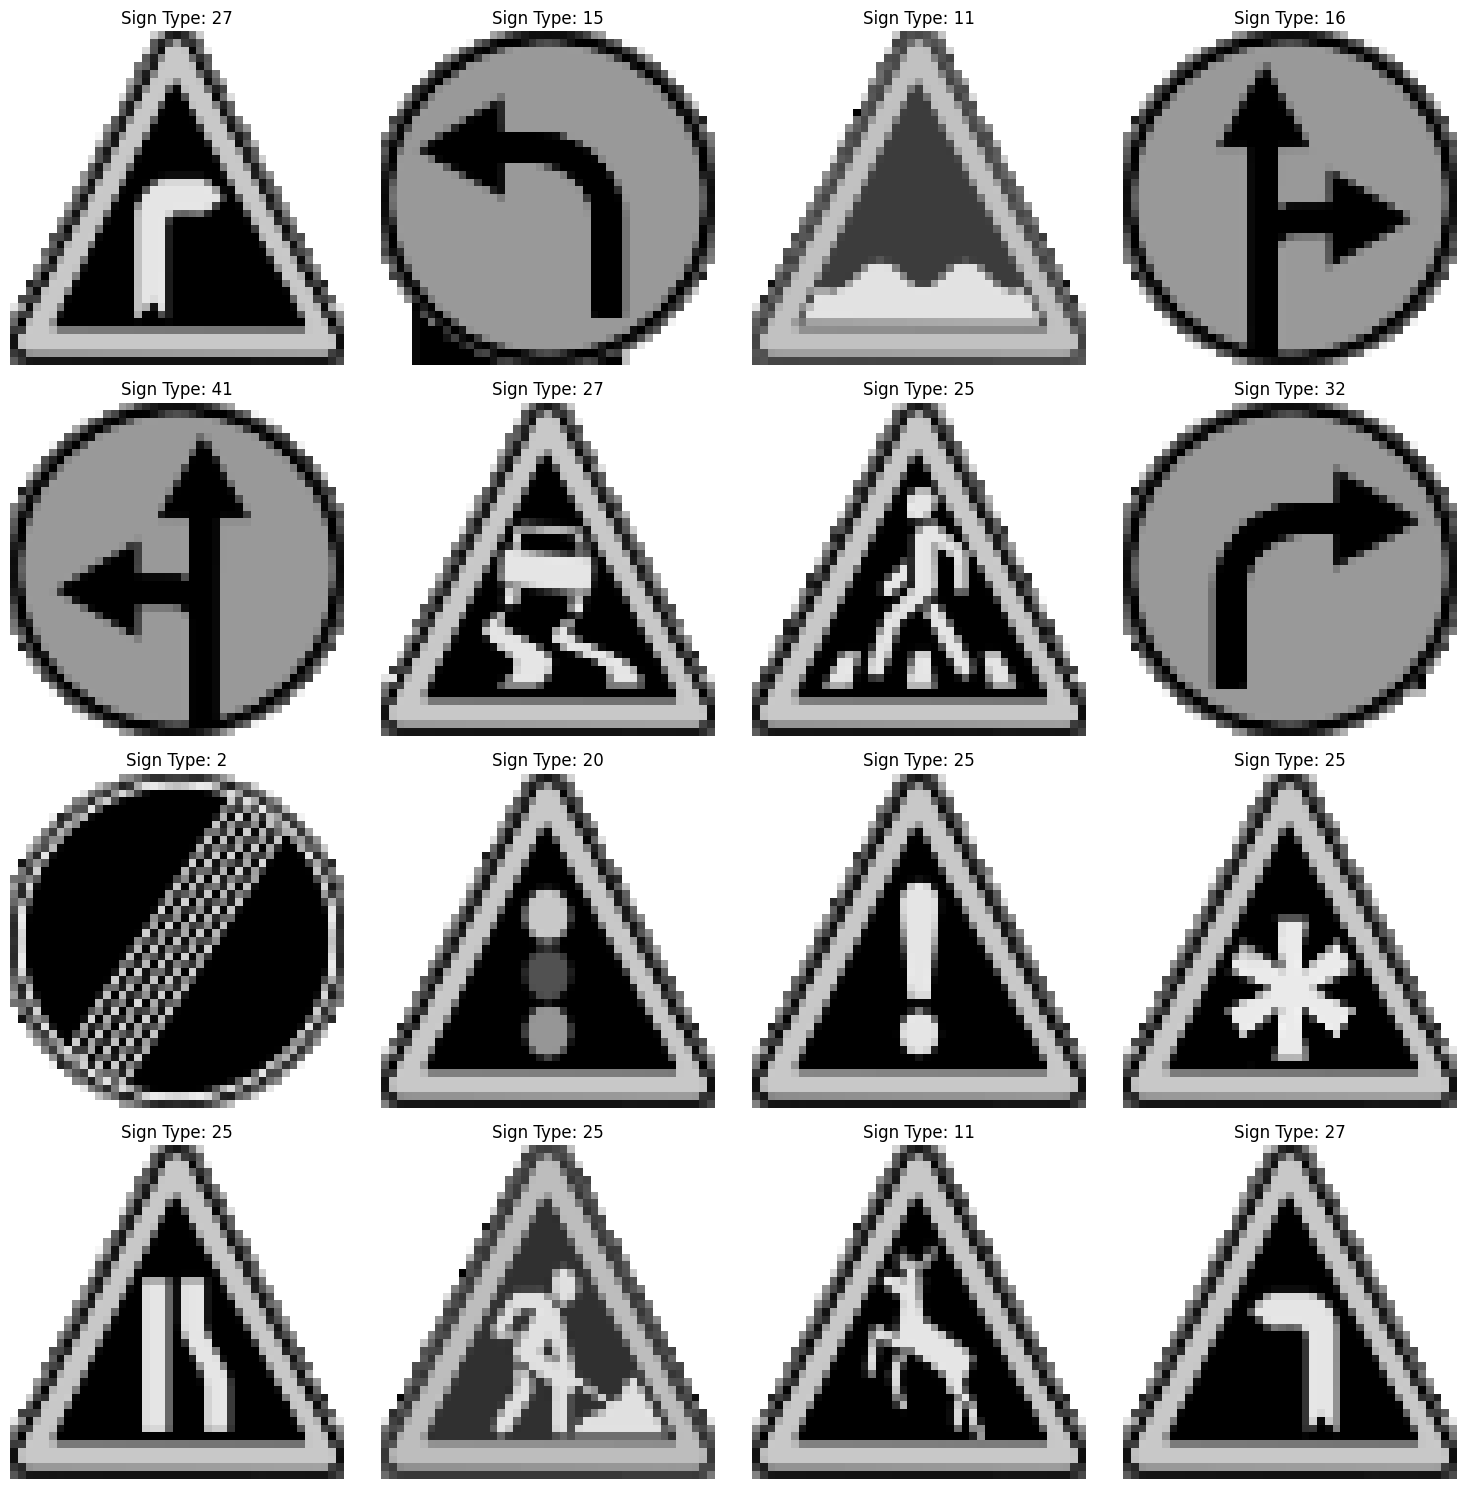

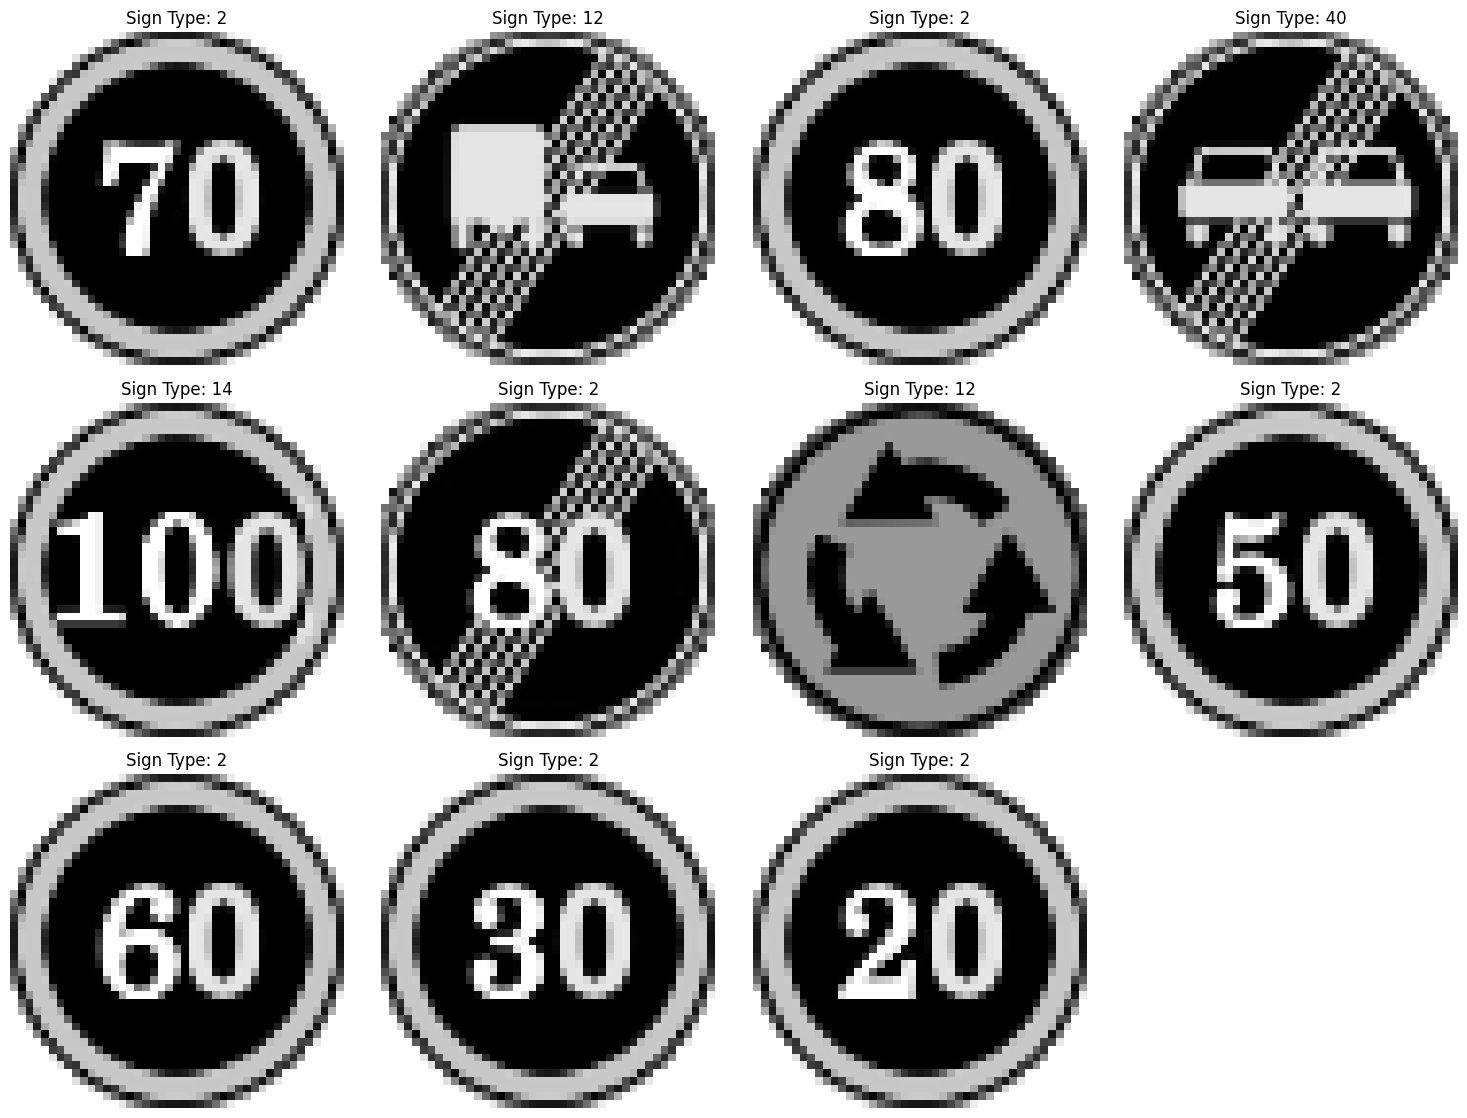

In [ ]:
test_image_path = 'data/Meta/'
test_images = glob.glob(os.path.join(test_image_path, '*.png'))

# Split into 16-image figures
num_images = len(test_images)
num_figures = (num_images - 1) // 16 + 1

for fig_num in range(num_figures):
    plt.figure(figsize=(15, 15))
    start_idx = fig_num * 16
    end_idx = min(start_idx + 16, num_images)
    
    for idx, image_path in enumerate(test_images[start_idx:end_idx]):
        # Process image
        img = Image.open(image_path)
        img_arr = np.asarray(img)
        img_rs = cv2.resize(img_arr, (43, 43))
        img_gray = cv2.cvtColor(img_rs, cv2.COLOR_BGR2GRAY)
        img_not = cv2.bitwise_not(img_gray)
        
        # Plot
        plt.subplot(4, 4, idx+1)
        plt.imshow(img_not, cmap=plt.get_cmap('gray'))
        plt.axis('off')
        
        # Prep for model
        img_not = img_not/255
        img_resh = img_not.reshape(1, 43, 43, 1)
        img_resh = np.repeat(img_resh, 3, axis=-1)
        
        # Predict
        prediction = np.argmax(model.predict(img_resh, verbose=0), axis=-1)
        plt.title(f'Sign Type: {prediction[0]}')

    plt.tight_layout()
    plt.show()